In [2]:
 # The really long way.
 # I create each of the individual two-port networks by hand and then combine them to make the full model

import skrf as rf
import numpy as npy
from skrf.constants import *
from skrf import mathFunctions as mf
%matplotlib inline
from pylab import * 
rf.stylely()

z0 = 50
T0 = 290. # Both resistors are set at room temperature for now
kB = K_BOLTZMANN
frequency = rf.Frequency(start=1000000, stop=1000000000000, npoints=100, unit='Hz', sweep_type='log')

Ic_ma = 20.1 # bias current in milliamps
beta0 = 107.7 # current gain,
cpi = 3.9e-12
cu = 0.8e-12
rbb = 5.303
ru = 100e9
rc = 0.5
re = 0.05
r0 = 1e4

gm = Ic_ma/26 # transconductance
rpi = beta0/gm # input resistance
gpi = 1/rpi
scpi = 1j*frequency.w*cpi
scu = 1j*frequency.w*cu
sug_d = scu - gm

ovec = npy.ones(len(frequency))
zvec = npy.zeros(len(frequency))

# Series base spreading resistance connected to base
rbb_series_y = rf.network_array([[1/rbb*ovec,  -1/rbb*ovec],
                                 [-1/rbb*ovec,  1/rbb*ovec]])
nwrk_rbb = rf.Network.from_y(rbb_series_y, frequency=frequency)
# See simple_noise_cascade.ipynb if you want to add the covariance matrix yourself. Here we use the 'passive' parameter, which calculates the covariance matrix for you.
nwrk_rbb.noise_source('passive')

# Series resistance connected to collector 
rc_series_y = rf.network_array([[1/rc*ovec,  -1/rc*ovec],
                                [-1/rc*ovec,  1/rc*ovec]])
nwrk_rc = rf.Network.from_y(rc_series_y, frequency=frequency)
nwrk_rc.noise_source('passive')

# Shunt resistor connected to emitter of transistor
re_shunt_z = rf.network_array([[re*ovec,  re*ovec],
                                [re*ovec,  re*ovec]])
nwrk_re = rf.Network.from_z(re_shunt_z, frequency=frequency)
nwrk_re.noise_source('passive')

# Series resistor parallel to common emitter 
ru_series_y = rf.network_array([[1/ru*ovec,  -1/ru*ovec],
                                [-1/ru*ovec,  1/ru*ovec]])
nwrk_ru = rf.Network.from_y(ru_series_y, frequency=frequency)
nwrk_ru.noise_source('passive')

r0_shunt_z = rf.network_array([[r0*ovec,  r0*ovec],
                                [r0*ovec,  r0*ovec]])
nwrk_r0 = rf.Network.from_z(r0_shunt_z, frequency=frequency)
nwrk_r0.noise_source('passive')         

# The next few networks are combined to create the BJT with parasitic capacitance. 
gpi_shunt_a = rf.network_array([[ovec,     zvec],
                                [gpi*ovec, ovec]])

cpi_shunt_a = rf.network_array([[ovec,     zvec],
                                [scpi*ovec, ovec]])

cug_shfb_a = rf.network_array([[scu/sug_d,     ovec/sug_d],
                               [scu*gm/sug_d,   scu/sug_d]])

# Multiply each ABCD form above for inner BJT model
a_bjt = npy.matmul(gpi_shunt_a, npy.matmul(cpi_shunt_a, cug_shfb_a))

# This covariance matrix that accounts for the shot noise within the BJT
cov_bjt_y = 2*kB*T0*gm*rf.network_array([[1/beta0*ovec,  zvec],
                                       [zvec,          ovec]])

nwrk_inner_bjt = rf.Network.from_a(a_bjt, frequency=frequency)
shot_noise_cov_y = rf.NetworkNoiseCov(cov_bjt_y, form='y')
nwrk_inner_bjt.noise_source(shot_noise_cov_y)

# Combine the networks together for the full Common Emitter two-port BJT model
ntwkT = rf.parallel_parallel_2port(nwrk_inner_bjt, nwrk_ru)
ntwkT = rf.cascade_2port(nwrk_rbb, ntwkT)
ntwkT = rf.cascade_2port(ntwkT, nwrk_r0)
ntwkT = rf.series_series_2port(ntwkT, nwrk_re)
ntwkT = rf.cascade_2port(ntwkT, nwrk_rc)

model_nfmin_db = ntwkT.nfmin_db
model_nf_db = ntwkT.nf_db(z0)
#sparams = mf.complex_2_db(ntwkT.s)
sparams = ntwkT.s_db
npy.max(sparams)

34.57851628283842

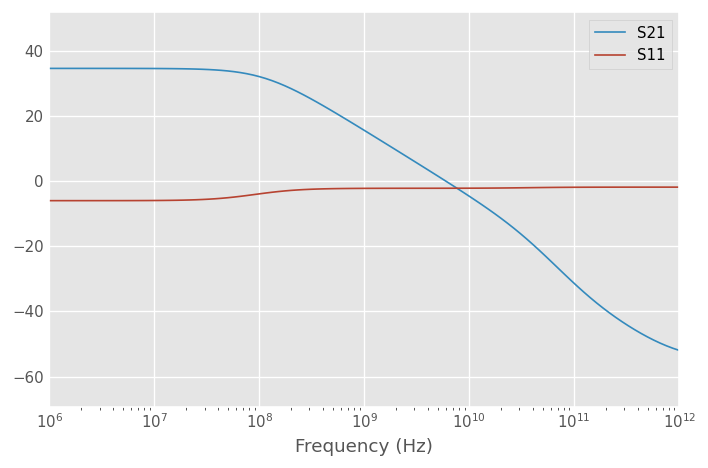

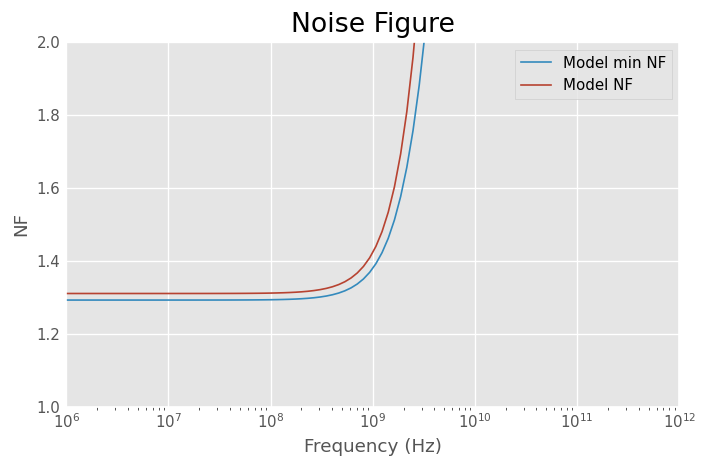

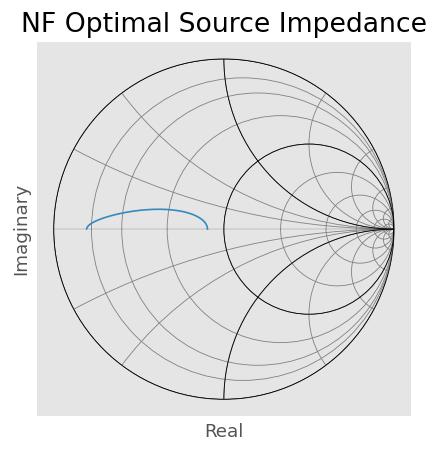

In [7]:
# Plot the results, the dashed lines represent the combined network from above and the solid lines are Fukui's results
from skrf.plotting import func_on_all_figs as foaf

figure(0)
semilogx(frequency.f_scaled, sparams[:,1,0], label=r'S21')
#semilogx(frequency.f_scaled, sparams[:,0,1], label=r'S12')
semilogx(frequency.f_scaled, sparams[:,0,0], label=r'S11')
#semilogx(frequency.f_scaled, sparams[:,1,1], label=r'S22')
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)
tight_layout()

figure(1)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, model_nfmin_db, label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db, label=r'Model NF')

ylim(1,2)
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)

tight_layout()

figure(2)
rf.plotting.plot_smith(ntwkT.g_opt, title="NF Optimal Source Impedance")


In [3]:
 # A little bit shorter way using components from scikit-rf library
 # I use resistor and capacitor components from the scikit-rf library and then combine them to make the full model

import skrf as rf
import numpy as npy
from skrf.constants import *
from skrf import mathFunctions as mf
%matplotlib inline
from pylab import * 
rf.stylely()

z0 = 50
T0 = 290. # Both resistors are set at room temperature for now
kB = K_BOLTZMANN
frequency = rf.Frequency(start=1000000, stop=1000000000000, npoints=100, unit='Hz', sweep_type='log')

Ic_ma = 20.1 # bias current in milliamps
beta0 = 107.7 # current gain,
cpi = 3.9e-12
cu = 0.8e-12
rbb = 5.303
ru = 100e9
rc = 0.5
re = 0.05
r0 = 1e4

nwrk_rbb = rf.components.RLC_Series_2port(R=rbb, frequency=frequency, T0 = 290)
nwrk_rc = rf.components.RLC_Series_2port(R=rc, frequency=frequency, T0 = 290)
nwrk_re = rf.components.RLC_Shunt_2port(R=re, frequency=frequency, T0 = 290)
nwrk_ru = rf.components.RLC_Series_2port(R=ru, frequency=frequency, T0 = 290)
nwrk_r0 = rf.components.RLC_Shunt_2port(R=r0, frequency=frequency, T0 = 290)

gm = Ic_ma/26 # transconductance
rpi = beta0/gm # input resistance

nwrk_rpi_cpi = rf.components.RLC_Shunt_2port(R=rpi, C=cpi, frequency=frequency, T0 = 290)
nwrk_rpi_cpi.noise_source('none') # transconductance not responsible for thermal noise

scu = 1j*frequency.w*cu
sug_d = scu - gm
cug_shfb_a = rf.network_array([[scu/sug_d,     1/sug_d],
                               [scu*gm/sug_d,   scu/sug_d]])
nwrk_inner_bjt = rf.Network.from_a(cug_shfb_a, frequency=frequency)
nwrk_inner_bjt.noise_source('none')

ntwk_bjt_shot_noise = rf.cascade_2port(nwrk_rpi_cpi, nwrk_inner_bjt)

# Model the shot noise using y form of the covariance matrix
ovec = npy.ones(len(frequency))
zvec = npy.zeros(len(frequency))
cov_bjt_y = 2*kB*T0*gm*rf.network_array([[1/beta0*ovec,  zvec],
                                         [zvec,          ovec]])

ntwk_bjt_shot_noise.noise_source(rf.NetworkNoiseCov(cov_bjt_y, form='y'))


ntwkT = rf.parallel_parallel_2port(ntwk_bjt_shot_noise, nwrk_ru)
ntwkT = rf.cascade_2port(nwrk_rbb, ntwkT)
ntwkT = rf.cascade_2port(ntwkT, nwrk_r0)
ntwkT = rf.series_series_2port(ntwkT, nwrk_re)
ntwkT = rf.cascade_2port(ntwkT, nwrk_rc)

model_nfmin_db = ntwkT.nfmin_db
model_nf_db = ntwkT.nf_db(z0)
sparams = ntwkT.s_db
npy.max(sparams)

34.5785162828384

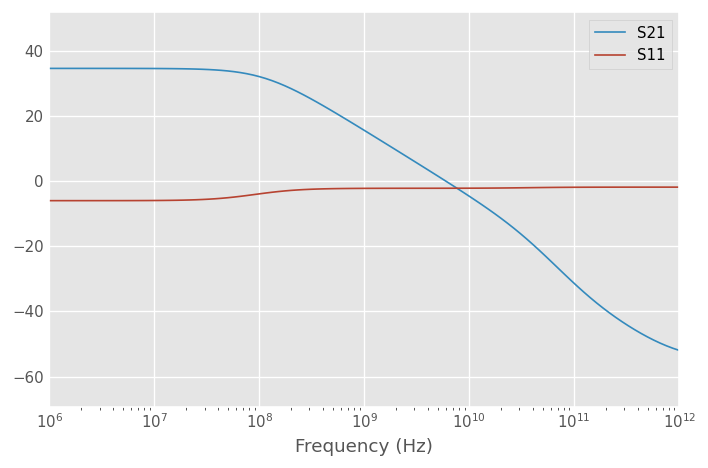

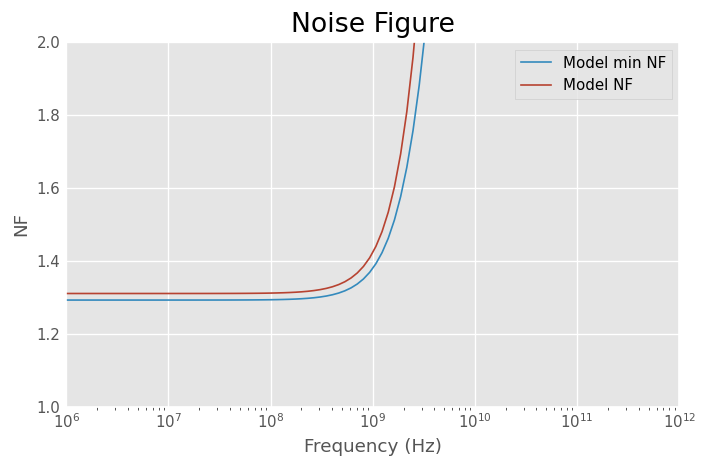

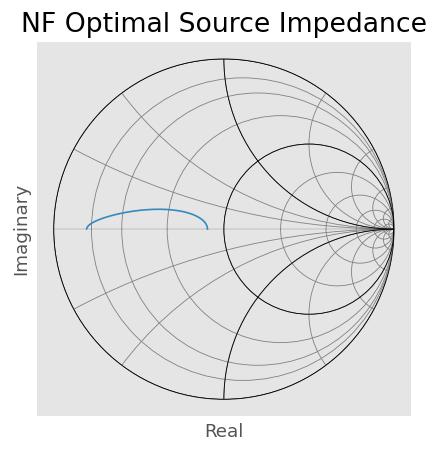

In [8]:
# Plot the results, the dashed lines represent the combined network from above and the solid lines are Fukui's results
from skrf.plotting import func_on_all_figs as foaf

figure(0)
semilogx(frequency.f_scaled, sparams[:,1,0], label=r'S21')
#semilogx(frequency.f_scaled, sparams[:,0,1], label=r'S12')
semilogx(frequency.f_scaled, sparams[:,0,0], label=r'S11')
#semilogx(frequency.f_scaled, sparams[:,1,1], label=r'S22')
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)
tight_layout()

figure(1)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, model_nfmin_db, label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db, label=r'Model NF')

ylim(1,2)
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)

tight_layout()

figure(2)
rf.plotting.plot_smith(ntwkT.g_opt, title="NF Optimal Source Impedance")

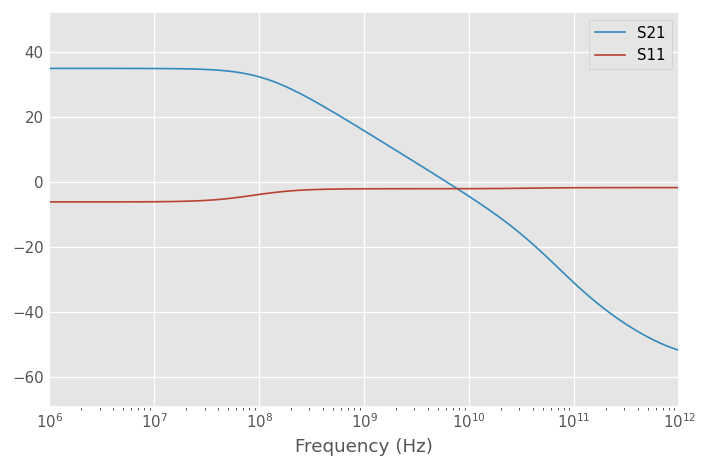

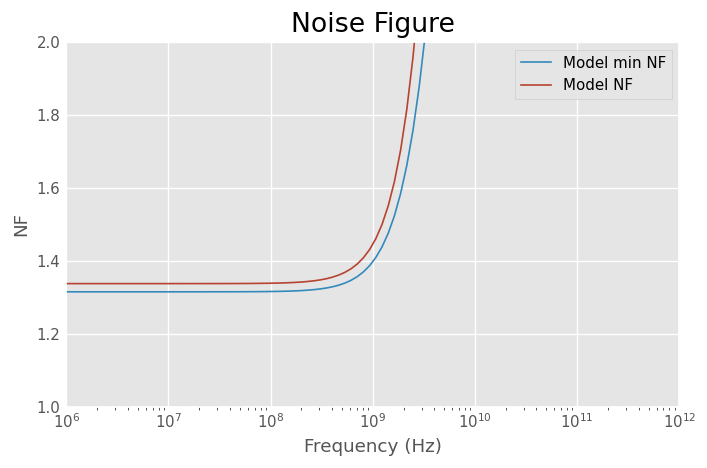

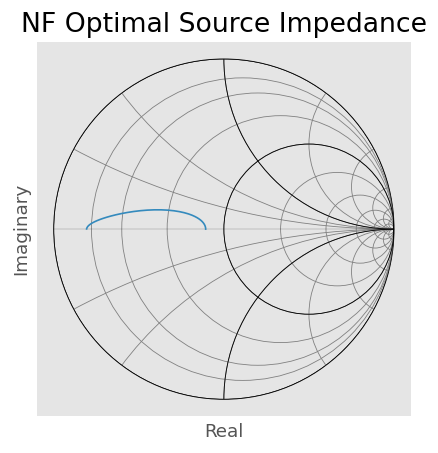

In [9]:
# The shortest way using SmallSig_NPN_BJT_CE_2port, this method simply uses the work from the previous cell
# With the code above, a new compenent called SmallSig_NPN_BJT_CE_2port was made. That component is used here.

import skrf as rf
import numpy as npy
from skrf.constants import *
from skrf import mathFunctions as mf
%matplotlib inline
from pylab import * 
rf.stylely()

Ic_ma = 20.1 # bias current in milliamps
beta0 = 107.7 # current gain,
cpi = 3.9e-12
cu = 0.8e-12
rbb = 5.303
ru = 100e9
rc = 0.5
re = 0.05
r0 = 1e4
cjx = 0
cjs = 0

frequency = rf.Frequency(start=1000000, stop=1000000000000, npoints=100, unit='Hz', sweep_type='log')

ntwkT = rf.components.SmallSig_NPN_BJT_CE_2port(Ic_ma, beta0, cpi, cu, rbb, rc, re, ru, r0, cjx, cjs, 
                                                frequency = frequency, T0 = 290)


model_nfmin_db = ntwkT.nfmin_db
z0 = 50
model_nf_db = ntwkT.nf_db(z0)
sparams = ntwkT.s_db
npy.max(sparams)                                

from skrf.plotting import func_on_all_figs as foaf

figure(0)
semilogx(frequency.f_scaled, sparams[:,1,0], label=r'S21')
#semilogx(frequency.f_scaled, sparams[:,0,1], label=r'S12')
semilogx(frequency.f_scaled, sparams[:,0,0], label=r'S11')
#semilogx(frequency.f_scaled, sparams[:,1,1], label=r'S22')
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)
tight_layout()

figure(1)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, model_nfmin_db, label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db, label=r'Model NF')

ylim(1,2)
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)

tight_layout()

figure(2)
rf.plotting.plot_smith(ntwkT.g_opt, title="NF Optimal Source Impedance")